# Lesson_6

## Импорт и подготовка данных

In [27]:
import numpy as np
import pandas as pd
from keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path

from warnings import filterwarnings
filterwarnings('ignore')


%cd ../input/camvid/CamVid/

[Errno 2] No such file or directory: '../input/camvid/CamVid/'
/kaggle/input/camvid/CamVid


In [28]:
classes = pd.read_csv('class_dict.csv')

In [29]:
shape_image = image.img_to_array(image.load_img(sorted(list(Path('./train').iterdir()))[0])).shape
shape_image

(720, 960, 3)

(128, 192, 3)


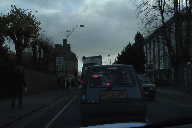

In [30]:
# Сильно большой формат фотографии, необходимо уменьшить
size = (128, 192)
img_1 = image.load_img(sorted(list(Path('./train').iterdir()))[0], target_size=(size))
print(image.img_to_array(img_1).shape)
img_1

(128, 192, 3)


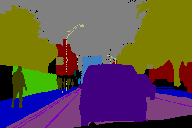

In [31]:
img_1 = image.load_img(sorted(list(Path('./train_labels').iterdir()))[0], target_size=(size))
print(image.img_to_array(img_1).shape)
img_1

In [32]:
train_imgs_paths = list(sorted(Path('./train').iterdir()))
train_masks_paths = list(sorted(Path('./train_labels').iterdir()))
test_imgs_paths = list(sorted(Path('./test').iterdir()))
test_masks_paths = list(sorted(Path('./test_labels').iterdir()))
val_imgs_paths = list(sorted(Path('./val').iterdir()))
val_masks_paths = list(sorted(Path('./val_labels').iterdir()))

In [33]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(image.load_img(i_img, target_size=size, color_mode='rgb'))
    train_masks.append(image.load_img(i_mask, target_size=size, color_mode='rgb'))

In [34]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(image.load_img(i_img, target_size=size, color_mode='rgb'))
    test_masks.append(image.load_img(i_mask, target_size=size, color_mode='rgb'))

In [35]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(image.load_img(i_img, target_size=size, color_mode='rgb'))
    val_masks.append(image.load_img(i_mask, target_size=size, color_mode='rgb'))

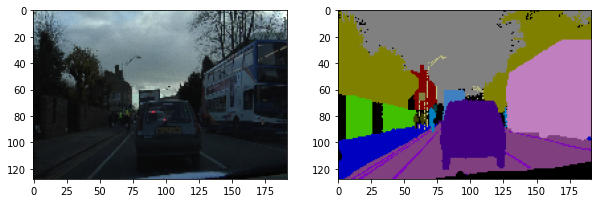

In [36]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(val_images[0])
plt.subplot(1, 2, 2)
plt.imshow(val_masks[0])
plt.show()

In [37]:
X_train = []

for img in train_images:
    X_train.append(image.img_to_array(img))
    
X_train = np.array(X_train)
X_train.shape

(369, 128, 192, 3)

In [38]:
X_test = []

for img in test_images:
    X_test.append(image.img_to_array(img))
    
X_test = np.array(X_test)
X_test.shape

(232, 128, 192, 3)

In [39]:
X_val = []

for img in val_images:
    X_val.append(image.img_to_array(img))
    
X_val = np.array(X_val)
X_val.shape

(100, 128, 192, 3)

In [40]:
classes.head(3)

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192


In [41]:
labels_cols = []

for r, g, b in zip(classes.r, classes.g, classes.b):
    labels_cols.append([r, g, b])

In [42]:

def Color2index(y, y_cols=labels_cols):
    """One Hot Encoder masks"""
    y_cat = np.zeros((y.shape[0], y.shape[1], len(labels_cols)))
    i = 0
    for i_color in labels_cols:
        ind_i = np.where(
            (y[..., 0] == i_color[0])
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        
        y_cat[ind_i[0], ind_i[1], i] = 1
        i += 1
        
    return y_cat

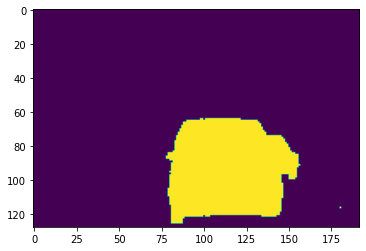

In [43]:
cat_yi = Color2index(image.img_to_array(train_masks[0]))
plt.imshow(cat_yi[..., 5])
plt.show()

In [44]:
# Создание таргетов

y_train = np.array([Color2index(image.img_to_array(i)) for i in train_masks])

y_test = np.array([Color2index(image.img_to_array(i)) for i in test_masks])

y_val = np.array([Color2index(image.img_to_array(i)) for i in val_masks])

## Создание модели

In [45]:
#метрика Dice
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

In [46]:
import tensorflow

from tensorflow.keras.layers import Activation, Input, MaxPooling2D, BatchNormalization,\
                            Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model

In [47]:
def Unet(num_classes, input_shape):
    img_input = Input(input_shape)

    #Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    
    # block 1 remember
    block_1_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_1_out)
    
    #Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    
    # block 2 remember
    block_2_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_2_out)
    
    #Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv_3')(x)
    x = BatchNormalization()(x)
    
    #block 3 remember
    block_3_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_3_out)
    
    #Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv_3')(x)
    x = BatchNormalization()(x)
    
    #block 4 remember
    block_4_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_4_out)
    
    #Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv_3')(x)
    x = BatchNormalization()(x)
    
    "Transpose"
    
    #transpose 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #transpose 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #transpose 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #transpose 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # classifier
    output = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    
    model = Model(img_input, output)
    
    return model

In [48]:
tensorflow.random.set_seed(22)

model_unet = Unet(y_train.shape[3], X_train[0, ...].shape)

model_unet.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

# model_unet.summary()

history = model_unet.fit(
    X_train, y_train,
    epochs=60,
    batch_size=1,
    validation_data=(X_val, y_val),
    callbacks=tensorflow.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
)

Epoch 1/60
369/369 [==============================] - 20s 48ms/step - loss: 1.0772 - dice_coef: 0.5607 - val_loss: 2.1251 - val_dice_coef: 0.3383
Epoch 2/60
369/369 [==============================] - 17s 45ms/step - loss: 0.8479 - dice_coef: 0.6424 - val_loss: 1.2029 - val_dice_coef: 0.5359
Epoch 3/60
369/369 [==============================] - 17s 45ms/step - loss: 0.7483 - dice_coef: 0.6828 - val_loss: 0.9335 - val_dice_coef: 0.6440
Epoch 4/60
369/369 [==============================] - 17s 46ms/step - loss: 0.6977 - dice_coef: 0.7032 - val_loss: 1.2587 - val_dice_coef: 0.5368
Epoch 5/60
369/369 [==============================] - 17s 46ms/step - loss: 0.6422 - dice_coef: 0.7250 - val_loss: 1.0597 - val_dice_coef: 0.5988
Epoch 6/60
369/369 [==============================] - 17s 45ms/step - loss: 0.6019 - dice_coef: 0.7431 - val_loss: 1.3066 - val_dice_coef: 0.5111
Epoch 7/60
369/369 [==============================] - 17s 46ms/step - loss: 0.5770 - dice_coef: 0.7510 - val_loss: 1.1303 - 

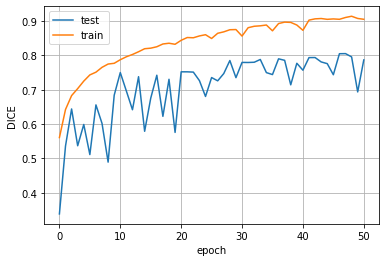

In [52]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('DICE')
plt.legend()
plt.show()

От увеличения количества блоков свертки увеличивается стабильность и качество предсказаний на валидационной выборке.
Также увеличение количества эпох до 35-40 увеличивается качество предсказаний.

In [70]:
preds = model_unet.predict(X_test)

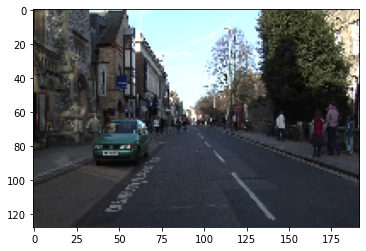

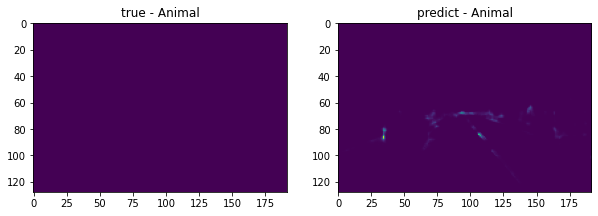

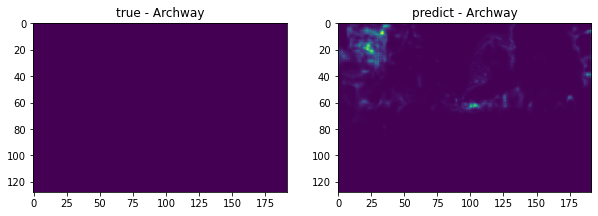

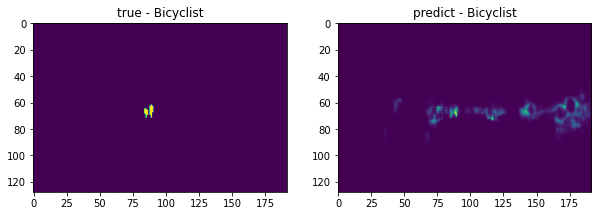

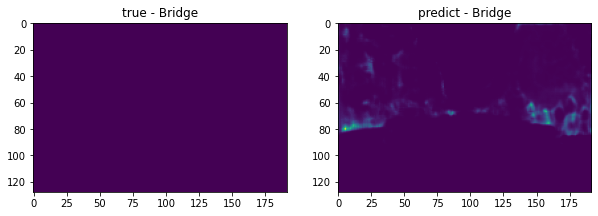

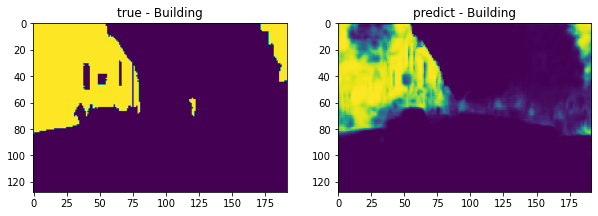

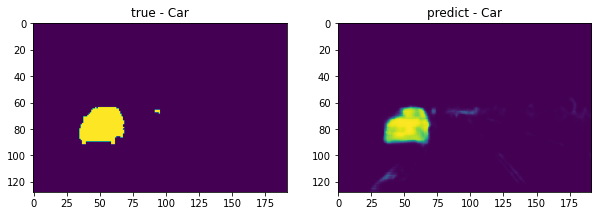

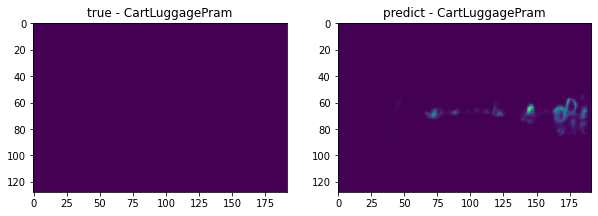

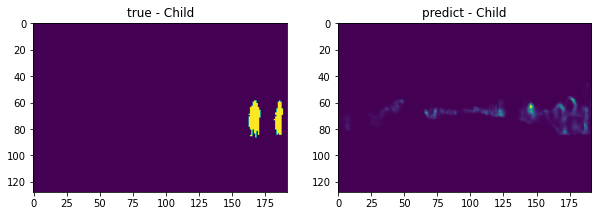

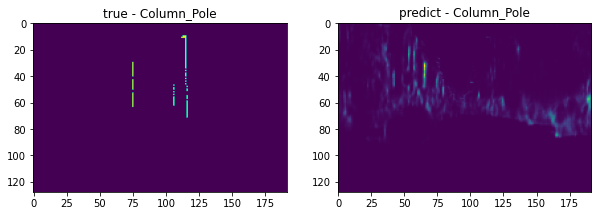

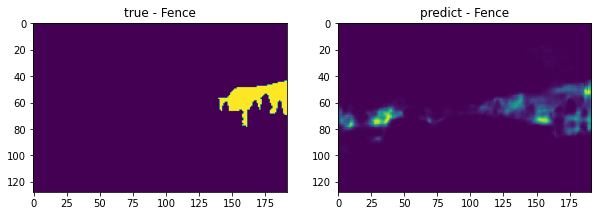

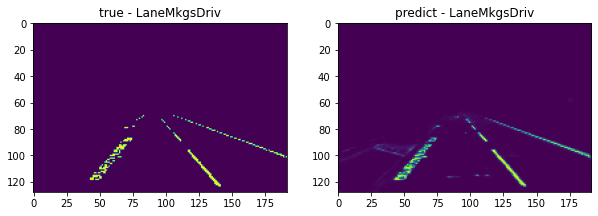

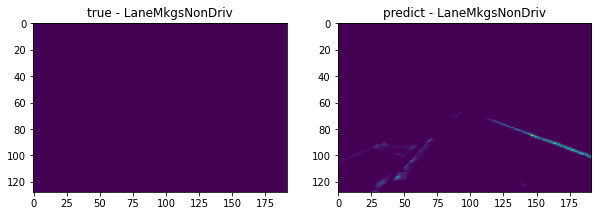

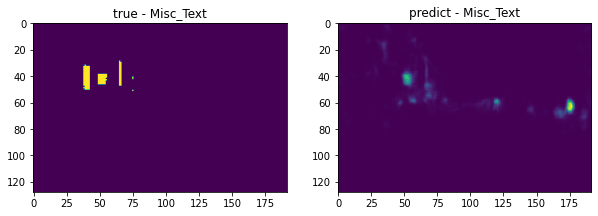

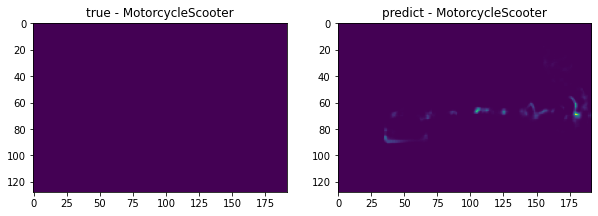

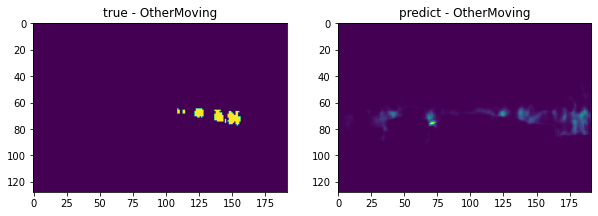

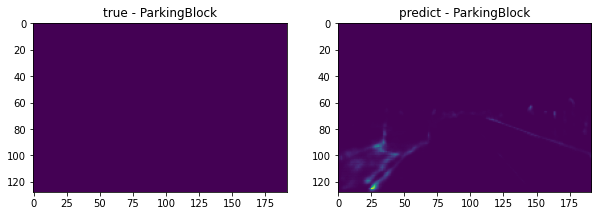

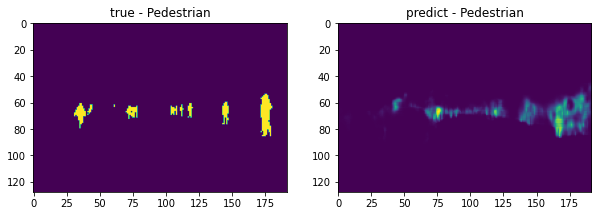

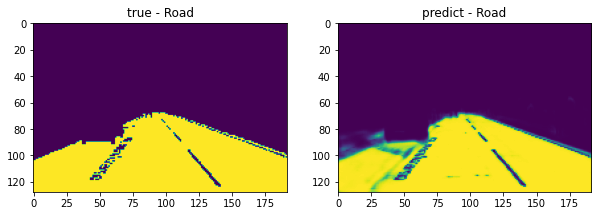

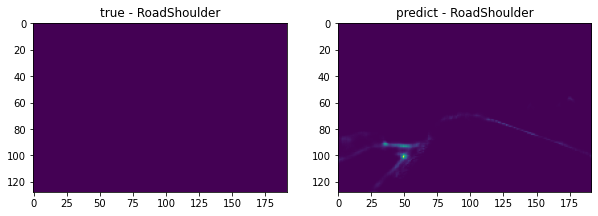

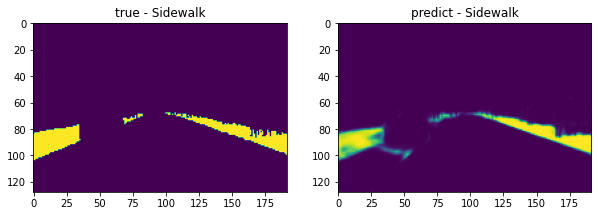

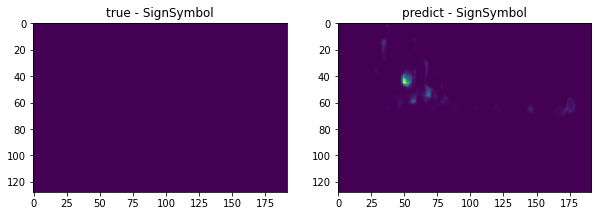

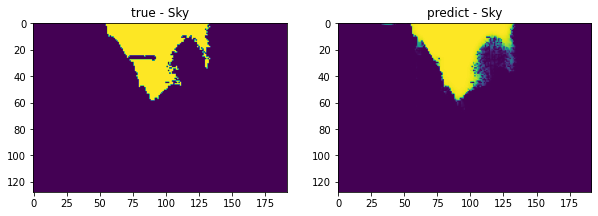

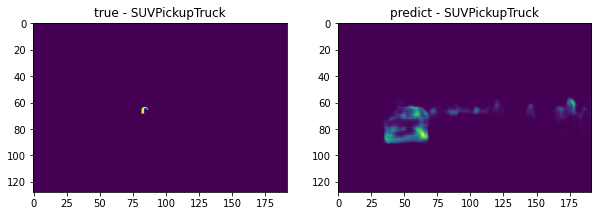

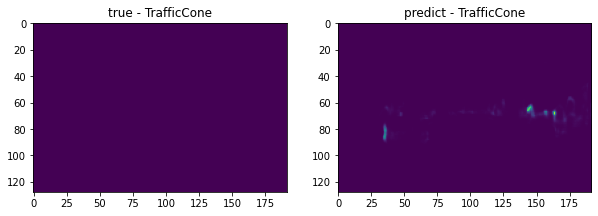

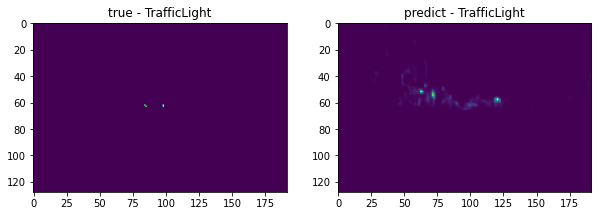

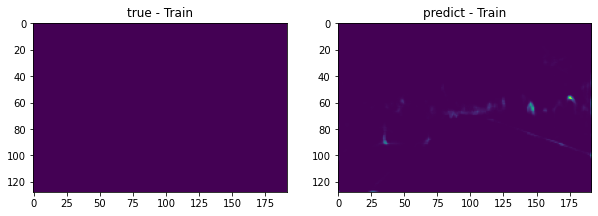

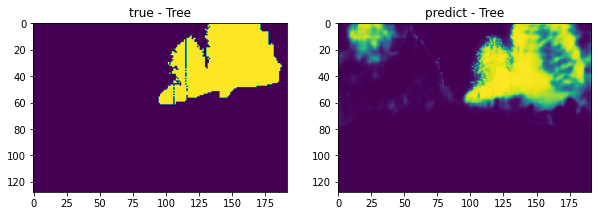

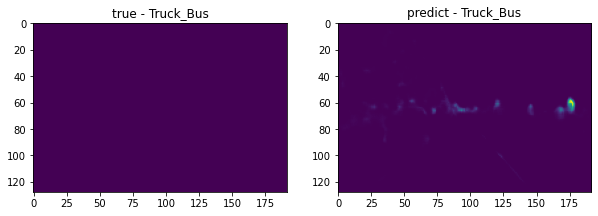

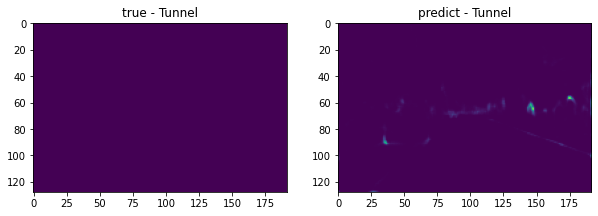

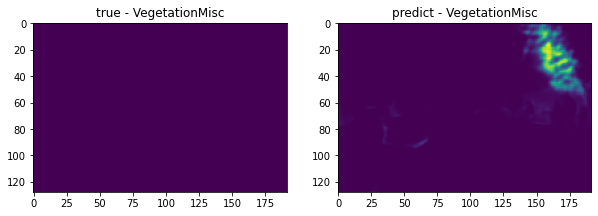

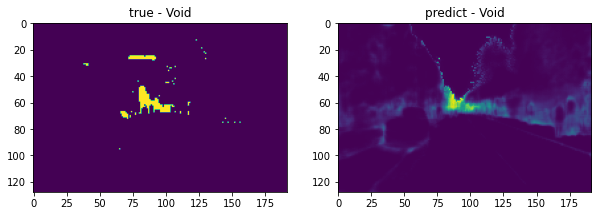

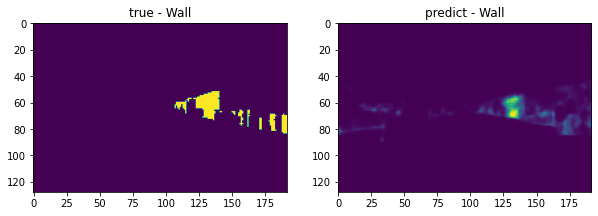

In [104]:
pred_num = 159

plt.imshow(image.array_to_img(X_test[pred_num]))

for i in range(len(labels_cols)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'true - {classes["name"][i]}')
    plt.imshow(y_test[pred_num, ..., i])
    plt.subplot(1, 2, 2)
    plt.imshow(preds[pred_num, ..., i])
    plt.title(f'predict - {classes["name"][i]}')
    plt.show()